In [2]:
import numpy as np
import shap
import transformers
from src.plot_text import text
from src.utils import (
    format_fts_for_plotting,
    text_ft_index_ends,
    legacy_get_dataset_info,
)
from src.run_shap import load_shap_vals_legacy as load_shap_vals
import pandas as pd
import datasets
from transformers import AutoTokenizer

# print the JS visualization code to the notebook
shap.initjs()

/home/james/CodingProjects/TextNTabularExplanations/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction to the problem

### SHAP values

In [3]:
# load the emotion dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True
)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion"
).cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

explainer = shap.Explainer(pred)
shap_values = explainer(data["text"][5:7])
shap.plots.text(shap_values)

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/james/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Multimodal SHAP issues

* Not possible to generate SHAP explanations for anything other than All-Text

And even then, this leads to issues:
* Tabular features are not treated as tabular features
* Ever present template tokens assigned importance
* Words erroneously grouped across features

![Alt text](image.png)

In [10]:
text_model_base = "distilbert-base-uncased"
text_model_code = "disbert"
ds = "imdb_genre"
idx = 10

di = legacy_get_dataset_info(ds)
shap_groups, names = load_shap_vals(
    ds, tab_scale_factor=1, text_model_code=text_model_code
)
shap_vals = shap_groups[-1]
shap.plots.text(
    shap.Explanation(
        values=shap_vals[idx].values,
        base_values=shap_vals[idx].base_values,
        data=shap_vals[idx].data,
        clustering=shap_vals[idx].clustering,
        output_names=di.label_names,
        hierarchical_values=shap_vals[idx].hierarchical_values,
    ),
    grouping_threshold=10,
)


## Problem

* How do we generate SHAP explanations for multimodal data?

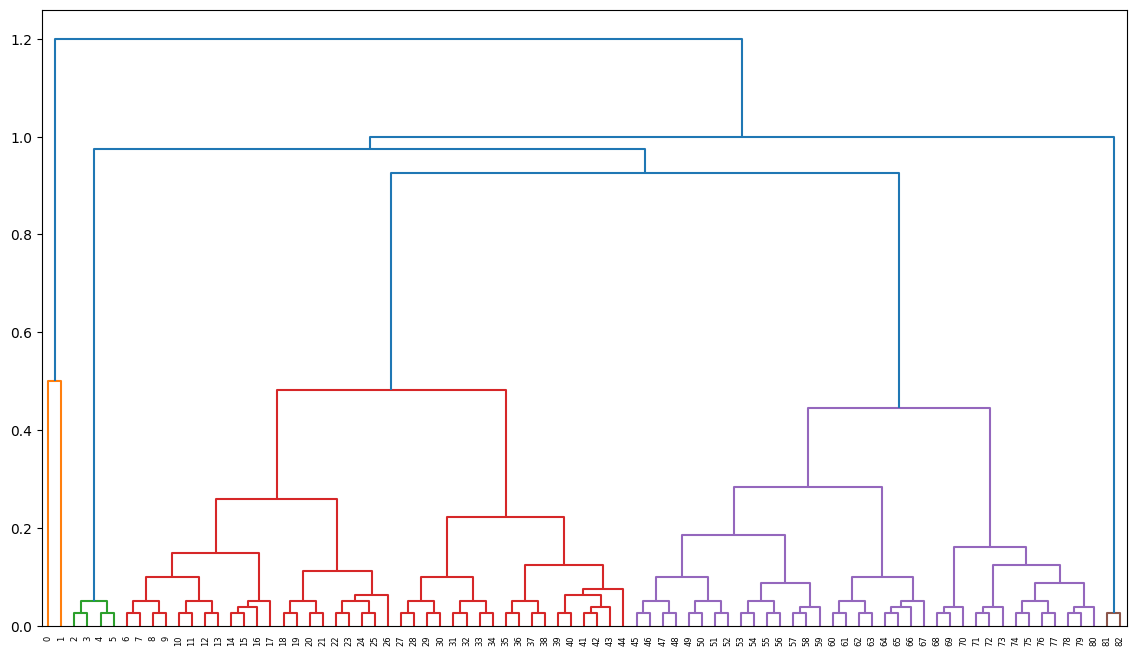

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

Z_join = np.array(
    [
        [0.00000000e00, 1.00000000e00, 5.00000000e-01, 2.00000000e00],
        [4.90000000e01, 5.00000000e01, 2.46913580e-02, 2.00000000e00],
        [6.40000000e01, 6.50000000e01, 2.46913580e-02, 2.00000000e00],
        [2.00000000e00, 3.00000000e00, 2.46913580e-02, 2.00000000e00],
        [4.00000000e00, 5.00000000e00, 2.46913580e-02, 2.00000000e00],
        [6.00000000e00, 7.00000000e00, 2.46913580e-02, 2.00000000e00],
        [8.00000000e00, 9.00000000e00, 2.46913580e-02, 2.00000000e00],
        [1.00000000e01, 1.10000000e01, 2.46913580e-02, 2.00000000e00],
        [1.20000000e01, 1.30000000e01, 2.46913580e-02, 2.00000000e00],
        [1.40000000e01, 1.50000000e01, 2.46913580e-02, 2.00000000e00],
        [1.80000000e01, 1.90000000e01, 2.46913580e-02, 2.00000000e00],
        [2.00000000e01, 2.10000000e01, 2.46913580e-02, 2.00000000e00],
        [2.20000000e01, 2.30000000e01, 2.46913580e-02, 2.00000000e00],
        [2.40000000e01, 2.50000000e01, 2.46913580e-02, 2.00000000e00],
        [2.70000000e01, 2.80000000e01, 2.46913580e-02, 2.00000000e00],
        [2.90000000e01, 3.00000000e01, 2.46913580e-02, 2.00000000e00],
        [3.10000000e01, 3.20000000e01, 2.46913580e-02, 2.00000000e00],
        [3.30000000e01, 3.40000000e01, 2.46913580e-02, 2.00000000e00],
        [3.50000000e01, 3.60000000e01, 2.46913580e-02, 2.00000000e00],
        [3.70000000e01, 3.80000000e01, 2.46913580e-02, 2.00000000e00],
        [3.90000000e01, 4.00000000e01, 2.46913580e-02, 2.00000000e00],
        [4.10000000e01, 4.20000000e01, 2.46913580e-02, 2.00000000e00],
        [4.50000000e01, 4.60000000e01, 2.46913580e-02, 2.00000000e00],
        [4.70000000e01, 4.80000000e01, 2.46913580e-02, 2.00000000e00],
        [5.10000000e01, 5.20000000e01, 2.46913580e-02, 2.00000000e00],
        [5.30000000e01, 5.40000000e01, 2.46913580e-02, 2.00000000e00],
        [5.50000000e01, 5.60000000e01, 2.46913580e-02, 2.00000000e00],
        [5.70000000e01, 5.80000000e01, 2.46913580e-02, 2.00000000e00],
        [6.00000000e01, 6.10000000e01, 2.46913580e-02, 2.00000000e00],
        [6.20000000e01, 6.30000000e01, 2.46913580e-02, 2.00000000e00],
        [6.80000000e01, 6.90000000e01, 2.46913580e-02, 2.00000000e00],
        [7.10000000e01, 7.20000000e01, 2.46913580e-02, 2.00000000e00],
        [7.40000000e01, 7.50000000e01, 2.46913580e-02, 2.00000000e00],
        [7.60000000e01, 7.70000000e01, 2.46913580e-02, 2.00000000e00],
        [7.80000000e01, 7.90000000e01, 2.46913580e-02, 2.00000000e00],
        [8.10000000e01, 8.20000000e01, 2.46913580e-02, 2.00000000e00],
        [9.20000000e01, 1.60000000e01, 3.70370370e-02, 3.00000000e00],
        [1.04000000e02, 4.30000000e01, 3.70370370e-02, 3.00000000e00],
        [8.50000000e01, 6.60000000e01, 3.70370370e-02, 3.00000000e00],
        [8.60000000e01, 8.70000000e01, 4.93827160e-02, 4.00000000e00],
        [8.80000000e01, 8.90000000e01, 4.93827160e-02, 4.00000000e00],
        [9.00000000e01, 9.10000000e01, 4.93827160e-02, 4.00000000e00],
        [9.30000000e01, 9.40000000e01, 4.93827160e-02, 4.00000000e00],
        [9.50000000e01, 9.60000000e01, 4.93827160e-02, 4.00000000e00],
        [9.70000000e01, 9.80000000e01, 4.93827160e-02, 4.00000000e00],
        [9.90000000e01, 1.00000000e02, 4.93827160e-02, 4.00000000e00],
        [1.01000000e02, 1.02000000e02, 4.93827160e-02, 4.00000000e00],
        [1.05000000e02, 1.06000000e02, 4.93827160e-02, 4.00000000e00],
        [8.40000000e01, 1.07000000e02, 4.93827160e-02, 4.00000000e00],
        [1.08000000e02, 1.09000000e02, 4.93827160e-02, 4.00000000e00],
        [1.11000000e02, 1.12000000e02, 4.93827160e-02, 4.00000000e00],
        [1.13000000e02, 7.00000000e01, 3.70370370e-02, 3.00000000e00],
        [1.15000000e02, 1.16000000e02, 4.93827160e-02, 4.00000000e00],
        [1.17000000e02, 8.00000000e01, 3.70370370e-02, 3.00000000e00],
        [1.03000000e02, 1.20000000e02, 6.17283951e-02, 5.00000000e00],
        [1.10000000e02, 5.90000000e01, 3.70370370e-02, 3.00000000e00],
        [1.21000000e02, 6.70000000e01, 4.93827160e-02, 4.00000000e00],
        [1.14000000e02, 7.30000000e01, 3.70370370e-02, 3.00000000e00],
        [1.19000000e02, 1.70000000e01, 4.93827160e-02, 4.00000000e00],
        [1.26000000e02, 2.60000000e01, 6.17283951e-02, 5.00000000e00],
        [1.37000000e02, 4.40000000e01, 7.40740741e-02, 6.00000000e00],
        [1.32000000e02, 1.38000000e02, 8.64197531e-02, 7.00000000e00],
        [1.35000000e02, 1.36000000e02, 8.64197531e-02, 7.00000000e00],
        [1.23000000e02, 1.24000000e02, 9.87654321e-02, 8.00000000e00],
        [1.27000000e02, 1.28000000e02, 9.87654321e-02, 8.00000000e00],
        [1.30000000e02, 1.31000000e02, 9.87654321e-02, 8.00000000e00],
        [1.33000000e02, 1.39000000e02, 9.87654321e-02, 8.00000000e00],
        [1.25000000e02, 1.42000000e02, 1.11111111e-01, 9.00000000e00],
        [1.29000000e02, 1.43000000e02, 1.23456790e-01, 1.00000000e01],
        [1.46000000e02, 1.41000000e02, 1.48148148e-01, 1.20000000e01],
        [1.40000000e02, 1.45000000e02, 1.23456790e-01, 1.00000000e01],
        [1.48000000e02, 1.44000000e02, 1.85185185e-01, 1.50000000e01],
        [1.47000000e02, 1.51000000e02, 2.22222222e-01, 1.80000000e01],
        [1.52000000e02, 1.50000000e02, 2.59259259e-01, 2.10000000e01],
        [1.34000000e02, 1.53000000e02, 1.60493827e-01, 1.30000000e01],
        [1.54000000e02, 1.49000000e02, 2.83950617e-01, 2.30000000e01],
        [1.58000000e02, 1.57000000e02, 4.44444444e-01, 3.60000000e01],
        [1.56000000e02, 1.55000000e02, 4.81481481e-01, 3.90000000e01],
        [1.60000000e02, 1.59000000e02, 9.25925926e-01, 7.50000000e01],
        [1.22000000e02, 1.61000000e02, 9.75308642e-01, 7.90000000e01],
        [1.62000000e02, 1.18000000e02, 1.00000000e00, 8.10000000e01],
        [8.30000000e01, 1.63000000e02, 1.20000000e00, 8.30000000e01],
    ]
)
fig = plt.figure(figsize=(14, 8))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
# , labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
dn = dendrogram(
    Z_join,
)
plt.show()

## Solution

![Alt text](maskers.png)

In [7]:
def display_shap_vals(ds_name, shap_groups, names, idx, text_model_name):
    di = legacy_get_dataset_info(ds_name)
    # names = ["Ensemble 25", "Ensemble 50",
    #         "Ensemble 75", "Stack Ensemble", "All as Text"]
    # shap_groups = [shap_25, shap_50, shap_75, shap_stack, shap_all_text]

    for shap_vals, name in zip(shap_groups[:-1], names[:-1]):
        print(
            f"""
            #################
            {name}
            #################
            """
        )
        # To format the text features, we find when the text features end and therefore
        # where to insert linebreaks
        tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        text_idxs = text_ft_index_ends(
            text_fts=shap_vals.data[idx][len(di.tab_cols) :], tokenizer=tokenizer
        )
        linebreak_before_idxs = [len(di.tab_cols)] + [
            x + len(di.tab_cols) + 1 for x in text_idxs
        ]

        formatted_data = np.array(
            format_fts_for_plotting(
                shap_vals[idx].feature_names, shap_vals[idx].data[: len(di.tab_cols)]
            )
        )
        text(
            shap.Explanation(
                values=shap_vals[idx].values,
                base_values=shap_vals[idx].base_values,
                data=formatted_data,
                clustering=shap_vals[idx].clustering,
                output_names=di.label_names,
                hierarchical_values=shap_vals[idx].hierarchical_values,
            ),
            # grouping_threshold=20,
            linebreak_before_idxs=linebreak_before_idxs,  # linebreak_after_idx,
            text_cols=di.text_cols,
            grouping_threshold=10,
        )
    print(
        f"""
            #################
            All as Text Baseline
            #################
            """
    )
    shap_vals = shap_groups[-1]
    shap.plots.text(
        shap.Explanation(
            values=shap_vals[idx].values,
            base_values=shap_vals[idx].base_values,
            data=shap_vals[idx].data,
            clustering=shap_vals[idx].clustering,
            output_names=di.label_names,
            hierarchical_values=shap_vals[idx].hierarchical_values,
        ),
        grouping_threshold=10,
    )

In [8]:
ds = "imdb_genre"
idx = 20

# shap_groups, names = load_shap_vals(ds)
shap_groups, names = load_shap_vals(
    ds, tab_scale_factor=1, text_model_code=text_model_code
)
display_shap_vals(ds, shap_groups, names, idx, text_model_base)



            #################
            ensemble_25
            #################
            



            #################
            ensemble_50
            #################
            



            #################
            ensemble_75
            #################
            



            #################
            stack
            #################
            



            #################
            all_text
            #################
            



            #################
            All as Text Baseline
            #################
            
